In [1]:
import sys
sys.path.append('../bin/')
from load_data import *
import matplotlib.pyplot as plt
from classification import *
import time

In [2]:
input_data = 'mnist'
num_classes= 10
DATA_SHAPE = 28*28
num_comp   = [50,200,500,DATA_SHAPE]
outpath    = '../outputs/%s/classification/'%input_data
covpath    = '../outputs/%s/covariance_estimator/'%input_data
plotpath   ='../outputs/%s/figures/'%input_data
modes      = ['ML','LW']
masks      = [True,False]

In [3]:
if input_data == 'mnist':
    load_data = load_mnist
if input_data == 'cifar10':
    load_data = load_cifar10

In [4]:
x_train, targets_train, x_test, targets_test = load_data()

In [5]:
def make_plots(x, input_type):

    num = np.int(np.floor(np.sqrt(len(x))))
    if num > 8:
        num = 8
    if input_type=='mnist':
        fig, axes = plt.subplots(num,num,figsize=(num,num))
        plt.set_cmap('gray')
        k =0
        for j in range(num):
            for i in range(num):
                k+=1
                axes[i][j].imshow(x[k].reshape(28,28))
                axes[i][j].axis('off')
        
        plt.show()
        
    elif input_type=='cifar10':
        fig, axes = plt.subplots(num,num,figsize=(num,num))
        k =0
        for j in range(num):
            for i in range(num):
                k+=1
                img = np.swapaxes(np.reshape((x[k]),(32,32,3),'F'),0,1)
                axes[i][j].imshow(img, interpolation='bilinear')
                axes[i][j].axis('off')
        plt.show()
    return True


In [6]:
from sklearn.covariance import LedoitWolf, EmpiricalCovariance, OAS
import scipy.linalg as lg
import numpy.linalg as nlg
from sklearn.decomposition import PCA

def get_covariance(R,var,num):
    '''
    get covarinace estimation for specific number of components
    num: number of components
    R: matrix of eigenvectors
    var: array of eigenvalues
    '''
    fl   = len(var)
    var_ = var[0:num]
    R    = R[0:num]
    
    if num<fl:
        sigma2 = np.mean(var[num::])
    else: 
        sigma2 = 0.

    C_            = np.dot(R.T,np.dot(np.diag(var_), R))+np.eye(len(R.T))*sigma2
    Cinv          = lg.inv(C_)
    sign ,logdetC = nlg.slogdet(C_)
    
    return Cinv, logdetC


class CovarianceEstimator():

    def __init__(self,mode, label, masking):
        
        assert(mode in ['ML','OAS', 'LW','NERCOME'])
        self.mode   = mode
        self.label  = label
        self.masking= masking
    
    def diag_decomp(self):
        # do svd for numerical stability (ensuring var>=0)
        U,s,V     = lg.svd(self.cov)
        indices   = np.argsort(s)[::-1]
        self.vars = s[indices]
        self.R    = V[indices]
        if len(np.where(self.vars==0.)[0])>0:
            print('covariance estimate contains singular eigenvalues')
        #print('svd ratio', np.mean(np.dot(np.dot(self.R.T,np.diag(self.vars)),self.R)/self.cov))
        return True
    
    def pca(self,data, mask_in, mask_out):
        
        data = self._data_prep(data, mask_in,mask_out)
        
        num       = data.shape[1]
        pca       = PCA(svd_solver='full',n_components=num)
        pca.fit(data)
        self.pca_vars= pca.explained_variance_
        self.pca_R   = pca.components_
        #print('pca ratio', np.mean(np.dot(np.dot(self.pca_R.T,np.diag(self.pca_vars)),self.pca_R)/self.cov))
        
    def _data_prep(self,data, mask_in, mask_out):
        
        if len(mask_in)==data.shape[1]:
            self.masking = False
            print('no zero variance pixels in data')
        
        if self.masking:
            data = data[:, mask_in]
        else:
            #inpainting white noise
            data[:,mask_out] = np.random.randn(np.prod(data.shape)).reshape(data.shape)[:,mask_out]*0.1
            
        self.mask_in = mask_in
        self.mask_out= mask_out
        self.mean = np.mean(data, axis=0)
        
        return data
        

    def fit(self,data, mask_in, mask_out):
        
        data = self._data_prep(data, mask_in,mask_out)
        
        if self.mode =='ML':
            self.cov = EmpiricalCovariance().fit(data).covariance_
        elif self.mode =='OAS':
            self.cov = OAS().fit(data).covariance_
        elif self.mode =='LW':
            self.cov = LedoitWolf().fit(data).covariance_
        elif mode == 'NERCOME':
            pass
        else: 
            raise ValueError
            
        #self.cov[np.where(self.cov==0.)]=1e-4


        return True
    
# numerically unstable 
#     def compute_logdet(self):
#         sign ,self.logdetC = nlg.slogdet(self.cov)
#         return True
# full thing is often note invertible, use decomposition
#     def compute_inverse(self):
#         self.Cinv = lg.inv(self.cov)
#         return True
    
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        if self.masking:
            self.filename = os.path.join(path,'cov_estimate_%s_%d_masked.pkl'%(self.mode,self.label))
        else:   
            self.filename = os.path.join(path,'cov_estimate_%s_%d.pkl'%(self.mode,self.label))
        
        pkl.dump(self, open(self.filename,'wb'))
        
        return self.filename

In [7]:
def prepare_data(data, labels, num_classes):
    '''
    orderes data by labels and identifies zero variance pixels
    '''
    ordered_data = []
    masks_in     = []
    masks_out    = []
    for ii in range(num_classes):
        ind     = np.where(labels==ii)[0]
        d       = data[ind]
        mask_in = np.where(np.var(d, axis=0)>0.)[0]
        ordered_data+=[d]
        mask_out= np.where(np.var(d, axis=0)==0.)[0]
        masks_in+=[mask_in]
        masks_out+=[mask_out]
    
    return ordered_data, masks_in, masks_out

In [8]:
d_v, mv_in, mv_out = prepare_data(data=x_train,labels=targets_train, num_classes=num_classes)
d_t, mt_in, mt_out = prepare_data(data=x_test,labels=targets_test, num_classes=num_classes)

In [9]:
def estimate_covariances(modes,masks,path):
    for mode in modes:
        for masking in masks:
            for ii, d in enumerate(d_v):
                if masking:
                    filename = os.path.join(path,'cov_estimate_%s_%d_masked.pkl'%(mode,ii))
                else:   
                    filename = os.path.join(path,'cov_estimate_%s_%d.pkl'%(mode,ii)) 
                if not os.path.isfile(filename):
                    cov = CovarianceEstimator(mode=mode,label=ii,masking=masking)
                    cov.fit(d,mv_in[ii],mv_out[ii])
                    cov.diag_decomp()          
                    cov.pca(d,mv_in[ii],mv_out[ii])
                    cov.save(path)
    return True

estimate_covariances(modes,masks,covpath)

True

In [10]:
def get_log_prob(logdet,Cinv,data,mean):
    d    = len(data)
    data = data-mean
    Cinv_d = np.einsum('jk,...k->...j',Cinv,data, optimize=True)
    logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d, optimize=True)
    return logprob

In [11]:
def classify(data,labels,covs, num_classes, num, pca=False):
    acc = []
    nums= []
    for jj in range(num_classes):
        indices = np.where(labels==jj)[0]
        dd      = data[indices]
        logprob = []
        for ii,cov in enumerate(covs):
            if cov.masking:
                d_      = dd[:,cov.mask_in]
            else:
                d_      = np.ones_like(dd)*0.01
                d_[:,cov.mask_in] = dd[:,cov.mask_in]
            if num > d_.shape[1]:
                num = d_.shape[1]
            if pca:
                Cinv, logdetC = get_covariance(cov.pca_R,cov.pca_vars,num)
            else:
                Cinv, logdetC = get_covariance(cov.R,cov.vars,num)
            logprob_= get_log_prob(logdetC,Cinv,d_,cov.mean)
            logprob+=[logprob_]
        acc+=[len(np.where(np.argsort(np.asarray(logprob),axis=0)[-1]==jj)[0])/len(dd)]
    return np.asarray(acc)

In [16]:
def perform_classification(modes, masks, inpath, outpath, pca=True):
    results = {}
    if pca:
        results['pca']={}
    for mode in modes:
        results[mode] ={}

        for masking in masks:
            if masking:
                label = 'masked'
            else:
                label = 'inpainted'
            results[mode][label]={}
            if pca and mode=='ML':
                results['pca'][label]={}
            covs=[]
            for ii in range(num_classes):
                if masking:
                    filename = os.path.join(inpath,'cov_estimate_%s_%d_masked.pkl'%(mode,ii))
                else:   
                    filename = os.path.join(inpath,'cov_estimate_%s_%d.pkl'%(mode,ii))
                covs+=[pkl.load(open(filename, 'rb'))]
            accs=[]
            nums=[]
            for num in num_comp:
                print('ML', num)
                acc  = classify(x_test,targets_test,covs, num_classes, num=num)
                accs+=[acc]
            results[mode][label]['accs']=np.asarray(accs)
            if pca:
                if mode=='ML':
                    accs=[]
                    for num in num_comp:
                        print('pca', num)
                        acc = classify(x_test,targets_test,covs, num_classes, num=num, pca=True)
                        accs+=[acc]
                    results['pca'][label]['accs']=np.asarray(accs)
            if not os.path.exists(outpath):
                os.makedirs(outpath)
            outfile = os.path.join(outpath,'results.pkl')
            pkl.dump(results, open(outfile, 'wb'))
    return results

results = perform_classification(modes,masks, inpath=covpath, outpath=outpath, pca=True)

ML 50
ML 200
ML 500
ML 784
pca 50
pca 200
pca 500
pca 784
ML 50
ML 200
ML 500
ML 784
pca 50
pca 200
pca 500
pca 784
ML 50
ML 200
ML 500
ML 784
ML 50
ML 200
ML 500
ML 784


In [17]:
results

{'LW': {'inpainted': {'accs': array([[ 0.99081633,  0.98325991,  0.96027132,  0.94059406,  0.96537678,
            0.9338565 ,  0.96764092,  0.92509728,  0.95277207,  0.94350842],
          [ 0.98061224,  0.96035242,  0.95251938,  0.92673267,  0.96741344,
            0.91479821,  0.95302714,  0.92412451,  0.93223819,  0.9197225 ],
          [ 0.96530612,  0.94096916,  0.95348837,  0.92079208,  0.93686354,
            0.87556054,  0.92797495,  0.90758755,  0.88501027,  0.86025768],
          [ 0.9622449 ,  0.95154185,  0.93992248,  0.92772277,  0.92260692,
            0.86434978,  0.93319415,  0.90661479,  0.86447639,  0.87215064]])},
  'masked': {'accs': array([[ 0.98469388,  0.94889868,  0.98837209,  0.94257426,  0.98167006,
            0.96300448,  0.94989562,  0.93385214,  0.90759754,  0.84737364],
          [ 0.95714286,  0.92422907,  0.98352713,  0.92079208,  0.9592668 ,
            0.91367713,  0.92066806,  0.92898833,  0.81724846,  0.76511397],
          [ 0.95      ,  0.9577092

In [14]:
import matplotlib
def make_acc_figure(modes,labels,results,path,plotname):
    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
    ls = ['-','--','-.',':',(0, (3, 5, 1, 5, 1, 5)),(0, (3, 1, 1, 1, 1, 1)),(0, (5, 10))]
    markers=['o','^','d','>','*','+']
    plt.figure()
    jj =0
    for mode in modes:
        for label in labels:
            for ii in range(num_classes):
                if ii ==0:
                    plt.plot(num_comp,results[mode][label]['accs'][:,ii],color=cmap(norm(ii)),marker=markers[jj],ls=ls[jj],label='%s, %s'%(mode,label))
                else:
                    plt.plot(num_comp,results[mode][label]['accs'][:,ii],color=cmap(norm(ii)),marker=markers[jj],ls=ls[jj])
            jj+=1
    plt.legend()
    plt.xlabel('# components')
    plt.ylabel('accuracies')
    if not os.path.exists(path):
        os.makedirs(path)
    filename = os.path.join(path,plotname)
    print(filename)
    plt.savefig(filename,bbox_inches='tight')
    plt.show()
    return True

../outputs/mnist/figures/MLvsPCA.png


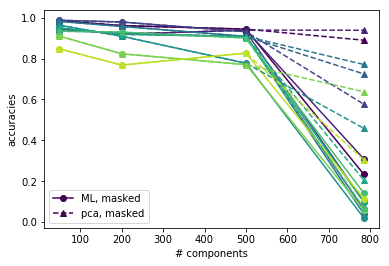

In [50]:
_=make_acc_figure(['ML','pca'],['masked'],results,plotpath, 'MLvsPCA.png')

../outputs/mnist/figures/MLvsLW_masked.png


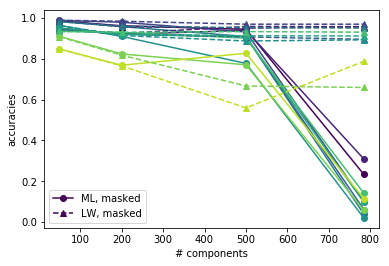

In [20]:
_=make_acc_figure(['ML','LW'],['masked'],results,plotpath, 'MLvsLW_masked.png')

../outputs/mnist/figures/MLvsLW_inpainted.png


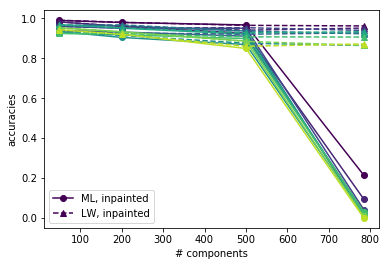

In [21]:
_=make_acc_figure(['ML','LW'],['inpainted'],results,plotpath, 'MLvsLW_inpainted.png')